# UNet implementation using pytorch for MRI segmentation
- unet: https://github.com/mateuszbuda/brain-segmentation-pytorch
- pytorch FLOP counter: https://github.com/sovrasov/flops-counter.pytorch

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import matplotlib.pyplot as plt
from pypapi import events, papi_high as high 
from ptflops import get_model_complexity_info


### Pre-trained example

In [8]:
init_features = 32
input_size = 256 #i.e. 256x256
n_channels = 3

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=True)
    
macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Computational complexity:       13.74 GMac
Number of parameters:           7.76 M  


### Try different input sizes with no-pretrained models

In [13]:
AI_models = ['UNet']
init_features_list = [16, 32, 64, 128, 256]
n_channels_list = [1]

FLOP_df = pd.DataFrame(columns=['model','input_size','init_filter_size','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0
for AI_model in AI_models:
    for init_features in init_features_list:
        for n_channels in n_channels_list:
            if AI_model == 'UNet':
                model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                    in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=False)
            else:
                print('Unknown AI model: {}'.format(AI_model))
                    
            macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                    print_per_layer_stat=False, verbose=False)

            FLOP_df.loc[i] = [AI_model,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
            i = i + 1

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [14]:
FLOP_df

,model,input_size,init_filter_size,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,UNet,256,16,1,3.44,GMac,1.94,M
1,UNet,256,32,1,13.7,GMac,7.76,M
2,UNet,256,64,1,54.65,GMac,31.04,M
3,UNet,256,128,1,218.28,GMac,124.12,M
4,UNet,256,256,1,872.49,GMac,496.42,M


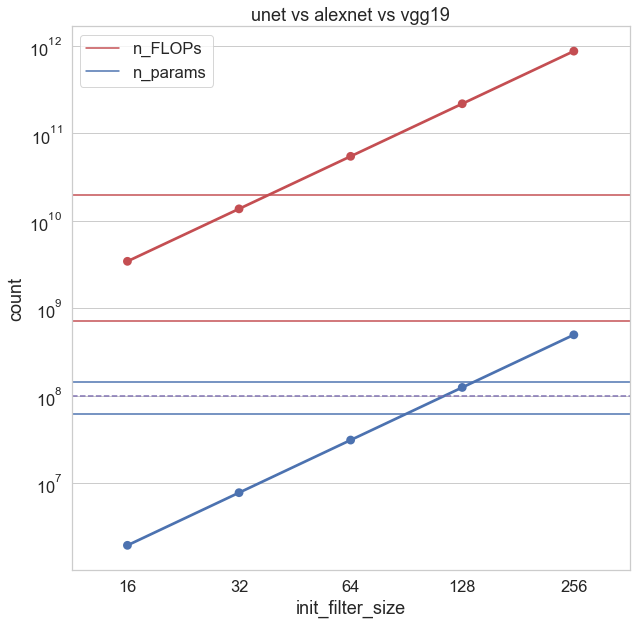

In [15]:

plot_df = FLOP_df[FLOP_df['n_channels']==1].copy()
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 
model_name = FLOP_df['model'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,10),sharex=True,sharey=True)
    g = sns.pointplot(x='init_filter_size',y='FLOPs', color='r', data=plot_df,ax=ax1,label='FLOPs')
    g = sns.pointplot(x='init_filter_size',y='n_parameters', color='b', data=plot_df, ax=ax1, label='n_params')

    
    ax1.axhline(0.72e9, color='r', linestyle='-',label='n_FLOPs')
    ax1.axhline(61e6, color='b', linestyle='-',label='n_params')
    ax1.axhline(19.7e9, color='r', linestyle='-')
    ax1.axhline(143e6, color='b', linestyle='-')

    ax1.axhline(1e8, color='m', linestyle='--')

    plt.legend()

    g.set(yscale="log") 
    plt.ylabel('count')
    plt.title('unet vs alexnet vs vgg19'.format(model_name))